In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 613MB/s] 


In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
from PIL import Image
import numpy as  np
import pandas as pd
import os


In [3]:
device= torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
image_path=[]
labels=[]

for i in os.listdir('animal-faces/afhq'):
    for label in os.listdir(f"animal-faces/afhq/{i}"):
        for img in os.listdir(f"animal-faces/afhq/{i}/{label}"):
            image_path.append(f"animal-faces/afhq/{i}/{label}/{img}")
            labels.append(label)

df=pd.DataFrame(zip(image_path,labels),columns=['image_path','labels'])
df.head()


,image_path,labels
0,animal-faces/afhq/train/cat/flickr_cat_000002.jpg,cat
1,animal-faces/afhq/train/cat/flickr_cat_000003.jpg,cat
2,animal-faces/afhq/train/cat/flickr_cat_000004.jpg,cat
3,animal-faces/afhq/train/cat/flickr_cat_000005.jpg,cat
4,animal-faces/afhq/train/cat/flickr_cat_000006.jpg,cat


In [6]:
df['labels'].unique()

array(['cat', 'dog', 'wild'], dtype=object)

In [7]:
train=df.sample(frac=0.7)
test=df.drop(train.index)

In [8]:
val=test.sample(frac=0.5)
test=test.drop(val.index)

In [9]:
print(train.shape)
print(val.shape)
print(test.shape)


(11291, 2)
(2420, 2)
(2419, 2)


In [10]:
encode=LabelEncoder()
encode.fit(df['labels'])

transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [30]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(encode.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image).to(device)
        return image, label

In [31]:
train_dataset=CustomDataset(dataframe=train,transform=transform)
val_dataset=CustomDataset(dataframe=val,transform=transform)
test_dataset=CustomDataset(dataframe=test,transform=transform)

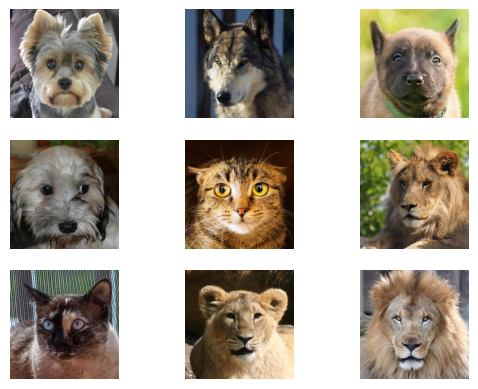

In [32]:
n_rows=3
n_col=3

f,axarr=plt.subplots(n_rows,n_col)

for row in range(n_rows):
    for col in range(n_col):
        img=Image.open(df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
        axarr[row,col].imshow(img)
        axarr[row,col].axis('off')

plt.show()

In [33]:
lr=1e-4
batch=16
epochs=10

In [34]:
train_loader=DataLoader(train_dataset,batch_size=batch,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch,shuffle=False)


In [35]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),   # halves spatial dims
            nn.Dropout2d(p=0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            

        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear((128*16*16),128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(64,len(df['labels'].unique()))
        )

    def forward(self,x):
        x=self.conv(x)
        x=self.classifier(x)
        return x

In [36]:
model=MyNN().to(device)

In [39]:
from torchsummary import summary
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
         Dropout2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
        MaxPool2d-13          [-1, 128, 16, 16]               0
          Flatten-14                [-1

In [40]:
criterion= nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=lr)

In [43]:
total_loss_train_plot=[]
total_loss_val_plot=[]
total_acc_train_plot=[]
total_acc_val_plot=[]

for epoch in range(epochs):
    total_loss_train=0
    total_loss_val=0
    total_acc_train=0
    total_acc_val=0

    for inputs,labels in train_loader:
        optimizer.zero_grad()
        output=model(inputs)

        train_loss=criterion(output,labels)
        total_loss_train+=train_loss.item()

        train_loss.backward()

        train_acc=(torch.argmax(output,axis=1)==labels).sum().item()
        total_acc_train+=train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs=model(inputs)
            val_loss=criterion(outputs,labels)
            total_loss_val+=val_loss.item()

            val_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
            total_acc_val+=val_acc

    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_val_plot.append(round(total_loss_val/1000,4))
    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
    total_acc_val_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))
    print(f'''Epoch {epoch+1}/{epochs}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
    print("="*25)

Epoch 1/10, Train Loss: 1.3853 Train Accuracy 93.0298
              Validation Loss: 0.2465 Validation Accuracy: 94.3802
Epoch 2/10, Train Loss: 0.9439 Train Accuracy 95.244
              Validation Loss: 0.1828 Validation Accuracy: 96.1157
Epoch 3/10, Train Loss: 0.6806 Train Accuracy 96.5282
              Validation Loss: 0.1671 Validation Accuracy: 95.9091
Epoch 4/10, Train Loss: 0.5188 Train Accuracy 97.3253
              Validation Loss: 0.1784 Validation Accuracy: 95.3719
Epoch 5/10, Train Loss: 0.4434 Train Accuracy 97.8301
              Validation Loss: 0.1778 Validation Accuracy: 96.2397
Epoch 6/10, Train Loss: 0.3819 Train Accuracy 98.0958
              Validation Loss: 0.1527 Validation Accuracy: 96.6116
Epoch 7/10, Train Loss: 0.3069 Train Accuracy 98.4412
              Validation Loss: 0.1536 Validation Accuracy: 96.9008
Epoch 8/10, Train Loss: 0.251 Train Accuracy 98.6361
              Validation Loss: 0.1763 Validation Accuracy: 96.3636
Epoch 9/10, Train Loss: 0.3077 Tra

In [45]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 95.0393 and Loss is 0.0281


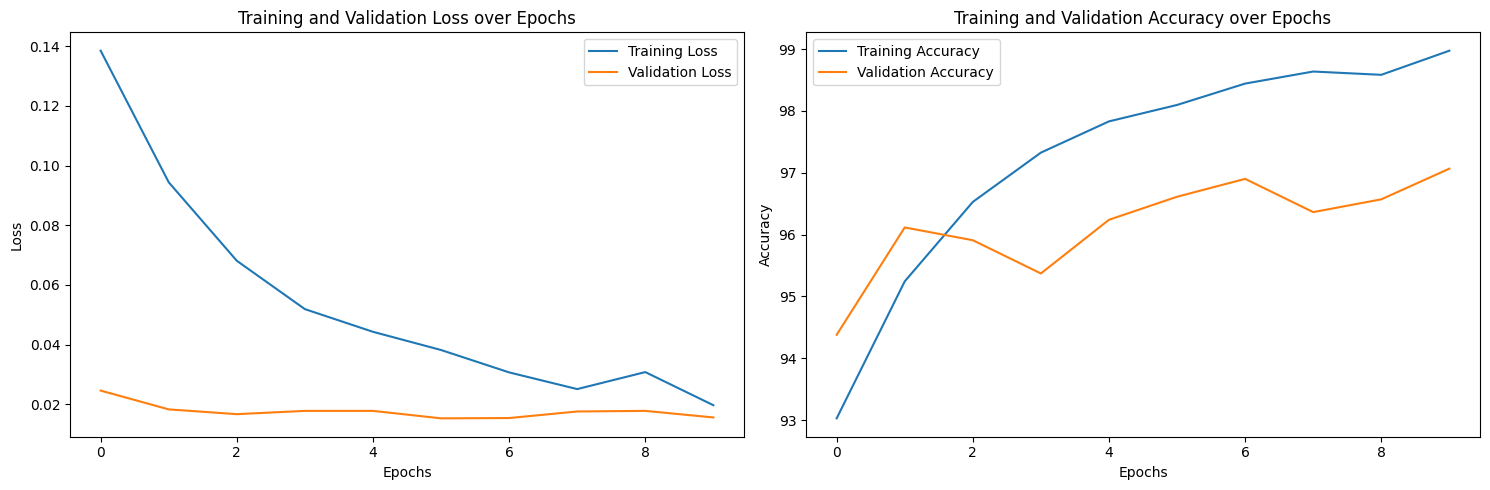

In [48]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

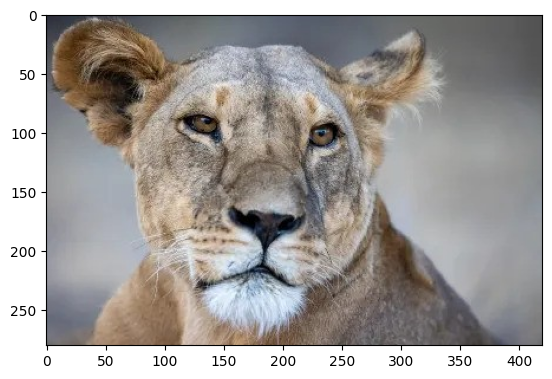


Prediction: 



array(['wild'], dtype=object)

In [53]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return encode.inverse_transform([output])

## Visualize the image
image = Image.open("animal-faces\lion-animal_GBV4APX0N7-ezgif.com-webp-to-jpg-converter.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("animal-faces\lion-animal_GBV4APX0N7-ezgif.com-webp-to-jpg-converter.jpg")